# Predicting Number of Degrees Awarded
## Jagos 
### 02/25/2022

### Introduction
Graduation rates in addition to retention rates are some of the most important statistics for educational institutions. Federal student aid defines it as, "the percentage of a school's first-time, first-year undergraduate students who complete their program within 150% of the published time for the program." High graduation rates demonstrate a school's commitment to students, reflecting a high level of institutional support and overall effectiveness. In this report I predict graduation rates by modeling the number of bachelors degrees awarded at an institution using various socio-economic variables. Lastly I identify 3 most stand out features/variables that influence the main variable. 

### Lit Review
The usage of machine learning in educational studies is new with most of the sources dated between 2014 and 2021. These papers were based in paricular schools or classes and mainly focused on predicting wether a student would be successful in the class. Sucess was usually measured using test scores or grades.<br>
<br>
Uskov et al for example used standard models such as k-nearest neighbor classification, naïve Bayes, artificial neural network (ANN) regression and classification, decision tree classification, random forest classification, and support vector machine classification to predict student academic performance in STEM education<a href="https://ieeexplore.ieee.org/abstract/document/8725237"> [1] </a>. This are some of the most commonly used models and simply using all of them. This work gave a comprehensive introduction to the models however tweaking the models would've been a better approach then simply running all of them (quality over quantity).<br>
<br>
Ahadi et al did just that by also using some different models such as the Bayesian Network<a href="https://opus.lib.uts.edu.au/bitstream/10453/37496/5/2015_08_ICER_AhadiEtAl_ExploringMachineLearningMethods_AcceptedManuscript.pdf"> [2] </a>. In their case they used machine learning to classify students into groups such wether they were doing fine and wether they needed help. Another notable fact is the usage of 10-fold-cross-validation which is generally preferred to a simple train-test split method as it gives the model the opportunity to train on multiple train-test splits.<br>
<br>
Lastly, the paper by Golino et al only used random forest to classify highschool students in a Computer Science class and predict their academic achievement. The model was able to achieve a 75% accuracy<a href="https://www.scirp.org/html/9-6901327_51702.htm?pagespeed=noscript"> [3] </a>.<br>
<br>

Overall, the literature is plentiful and methodologies are robust. This report only contributes to the literature in scale, that is the data used is not focused on classrooms or individual schools but more on the national level.
Even though the papers used various models, in all 3 random forest and ANN significantly outperformed the rest. Therefore, in this report I will be focusing on the Random Forest as ANNs would require a change in how I approach my data. 




### Methodology
The data comes from the National Center for Education Statistics, more specifically IPEDS Analytics: Delta Cost Project Database. There you will find a longitudinal database derived from IPEDS finance, enrollment, staffing, completions and student aid data for academic years 1986-87 through 2011-12. I will talk about my methodology as we go through the code. <a href="https://nces.ed.gov/ipeds/deltacostproject/">[Link to dataset].</a>

In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import missingno as msno
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# Importing dataset
df = pd.read_csv('delta_public_00_12.csv',encoding='latin1', low_memory = False)

#### Feature Selection
The dataset cointains 974 variables with our variable of interest "bachelordegrees". In order to reduce model complexity, enhance efficiency, and reduce noise we need to perform some sort of feature selection. First I used the pandas package to visualize the correlations of every variable. Based on the literature as well as the figure I picked the variables with the highest correlation to the target variable. 

In [3]:
# Notebook won't show on github if i run it

#corr = df.corr()
#corr.style.background_gradient(cmap='coolwarm')

In [3]:
# Making a new subset with selected features
df_subset = df[['bachelordegrees','sector','flagship','state03',
                'private03','edactivity03','unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant05','grant06','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01',
               'studserv01_fasb','ftretention_rate','total_enrollment_amin_tot',
               'dependent1']]
df_subset

,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,...,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
0,20.0,3,0,NaN,NaN,NaN,2895011.0,20138.0,1046625.0,211276.0,...,12.0,12.0,NaN,NaN,NaN,882337.717575,NaN,1.00,3.0,NaN
1,NaN,9,0,NaN,9000.0,NaN,947300.0,196340.0,198269.0,NaN,...,19.0,15.0,NaN,NaN,NaN,106040.267022,NaN,0.69,0.0,NaN
2,516.0,2,0,NaN,NaN,NaN,21079005.0,2067400.0,4390892.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN
3,NaN,9,0,NaN,NaN,NaN,699988.0,NaN,393685.0,NaN,...,13.0,13.0,NaN,NaN,NaN,NaN,NaN,0.84,0.0,NaN
4,NaN,6,0,NaN,NaN,NaN,1130401.0,18397.0,361836.0,11101.0,...,101.0,96.0,NaN,NaN,NaN,867440.029060,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87555,23.0,3,0,NaN,NaN,NaN,5033370.0,74168.0,1306516.0,42408.0,...,33.0,28.0,NaN,NaN,NaN,795911.296036,NaN,0.50,1.0,NaN
87556,29.0,3,0,NaN,NaN,NaN,8864391.0,261221.0,1070872.0,33008.0,...,21.0,17.0,NaN,NaN,NaN,452589.373268,NaN,0.58,1.0,NaN
87557,3.0,3,0,NaN,NaN,NaN,1627658.0,60055.0,382504.0,18250.0,...,10.0,10.0,NaN,NaN,NaN,157952.111494,NaN,0.50,1.0,NaN
87558,8.0,3,0,NaN,NaN,NaN,2165955.0,72265.0,514270.0,15968.0,...,11.0,10.0,NaN,NaN,NaN,549126.810692,NaN,0.75,0.0,NaN


In [5]:
# Closer look at the correlations
corr = df_subset.corr()
corr.style.background_gradient(cmap='coolwarm')

,bachelordegrees,sector,flagship,state03,private03,edactivity03,unrestricted_revenue,appliedaid01,grant01,grant02,grant03,grant05,grant06,grant07,institutional_grant_aid,any_aid_num,loan_num,acadsupp01,acadsupp01_fasb,acadsupp02,studserv01,studserv01_fasb,ftretention_rate,total_enrollment_amin_tot,dependent1
bachelordegrees,1.000000,-0.283102,0.443612,0.864964,0.332659,0.323833,0.655382,0.640379,0.611473,0.436294,0.597934,0.373139,0.383406,0.717420,0.462386,0.720123,0.537300,0.642740,0.606254,0.627899,0.735065,0.707862,0.181474,0.318982,0.499271
sector,-0.283102,1.000000,-0.054644,-0.333257,-0.118081,-0.134536,-0.215602,-0.252817,-0.170538,-0.143850,-0.181949,-0.134074,-0.167137,-0.259430,-0.196535,-0.207156,-0.152774,-0.188528,-0.139860,-0.174392,-0.288265,-0.188928,0.115099,-0.145687,-0.117829
flagship,0.443612,-0.054644,1.000000,0.473107,0.166878,0.161924,0.314704,0.244463,0.135514,0.208465,0.156326,0.217385,0.173717,0.264725,0.225574,0.298521,0.210142,0.344756,0.309658,0.348759,0.277044,0.259686,0.076598,0.254484,0.130323
state03,0.864964,-0.333257,0.473107,1.000000,0.347645,0.302491,0.794386,0.618925,0.622737,0.455711,0.595245,0.494001,0.298103,0.663943,0.384363,0.819978,0.687358,0.688815,0.618852,0.654239,0.764361,0.741337,0.280724,0.277188,0.594799
private03,0.332659,-0.118081,0.166878,0.347645,1.000000,0.665106,0.680875,0.684921,0.105963,0.498024,0.130238,0.757803,0.613149,0.622183,0.739227,0.260336,0.275448,0.614204,0.635242,0.558508,0.565860,0.598809,0.249312,0.070490,0.086102
edactivity03,0.323833,-0.134536,0.161924,0.302491,0.665106,1.000000,0.511038,0.525025,0.162503,0.554708,0.192033,0.528459,0.448568,0.502227,0.548336,0.213131,0.170266,0.622805,0.622196,0.570620,0.491149,0.490302,0.106522,0.116991,0.091147
unrestricted_revenue,0.655382,-0.215602,0.314704,0.794386,0.680875,0.511038,1.000000,0.734206,0.420916,0.476604,0.399443,0.609942,0.475305,0.709133,0.605225,0.505994,0.381947,0.674233,0.639155,0.637592,0.717183,0.681415,0.128762,0.220773,0.344858
appliedaid01,0.640379,-0.252817,0.244463,0.618925,0.684921,0.525025,0.734206,1.000000,0.412961,0.512947,0.452800,0.646302,0.897593,0.910636,0.929439,0.504536,0.347252,0.676414,0.699408,0.624775,0.789647,0.821995,0.252429,0.166941,0.340611
grant01,0.611473,-0.170538,0.135514,0.622737,0.105963,0.162503,0.420916,0.412961,1.000000,0.463574,0.437717,0.155178,0.173245,0.661221,0.204971,0.714073,0.557924,0.375054,0.349018,0.364241,0.595971,0.534241,-0.046916,0.322880,0.845664
grant02,0.436294,-0.143850,0.208465,0.455711,0.498024,0.554708,0.476604,0.512947,0.463574,1.000000,0.231727,0.508765,0.329034,0.564694,0.397996,0.333281,0.270215,0.496965,0.463771,0.490092,0.511559,0.520263,0.100577,0.173946,0.237733


#### Handling Missing Values issues
Missing data is a common problem for many dataset and this one is no exception. Handling missing data depends in which mechanism it falls into.<br>

- Missing completely at random (MCAR) where missing observations are not reliant on the observed and unobserved measurements<a href="https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9"> [4] </a>.
- Missing at random (MAR) where the likelihood of a missing value in MAR is only related to the observable data<a href="https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9"> [4] </a>.
- Missing not at random (MNAR) where missing data is neither MCAR nor MAR so it depends equally on the missing and observed values<a href="https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9"> [4] </a>.

Therefore we need to explore further.


In [6]:
#Num of missing values
df_subset.isna().sum()

bachelordegrees              33720
sector                           0
flagship                         0
state03                      65089
private03                    51139
edactivity03                 60060
unrestricted_revenue         12374
appliedaid01                 40303
grant01                      17895
grant02                      34563
grant03                      41976
grant05                      57135
grant06                      56860
grant07                      13987
institutional_grant_aid      40362
any_aid_num                  18846
loan_num                     18885
acadsupp01                   45428
acadsupp01_fasb              59906
acadsupp02                   50719
studserv01                   19328
studserv01_fasb              59657
ftretention_rate             43293
total_enrollment_amin_tot    11291
dependent1                   55286
dtype: int64

##### Understainding the heatmap
The heatmap function shows that there are strong correlations between missing values of different features. Generally low correlations  indicate that the data are missing at random (MAR).

<AxesSubplot:>

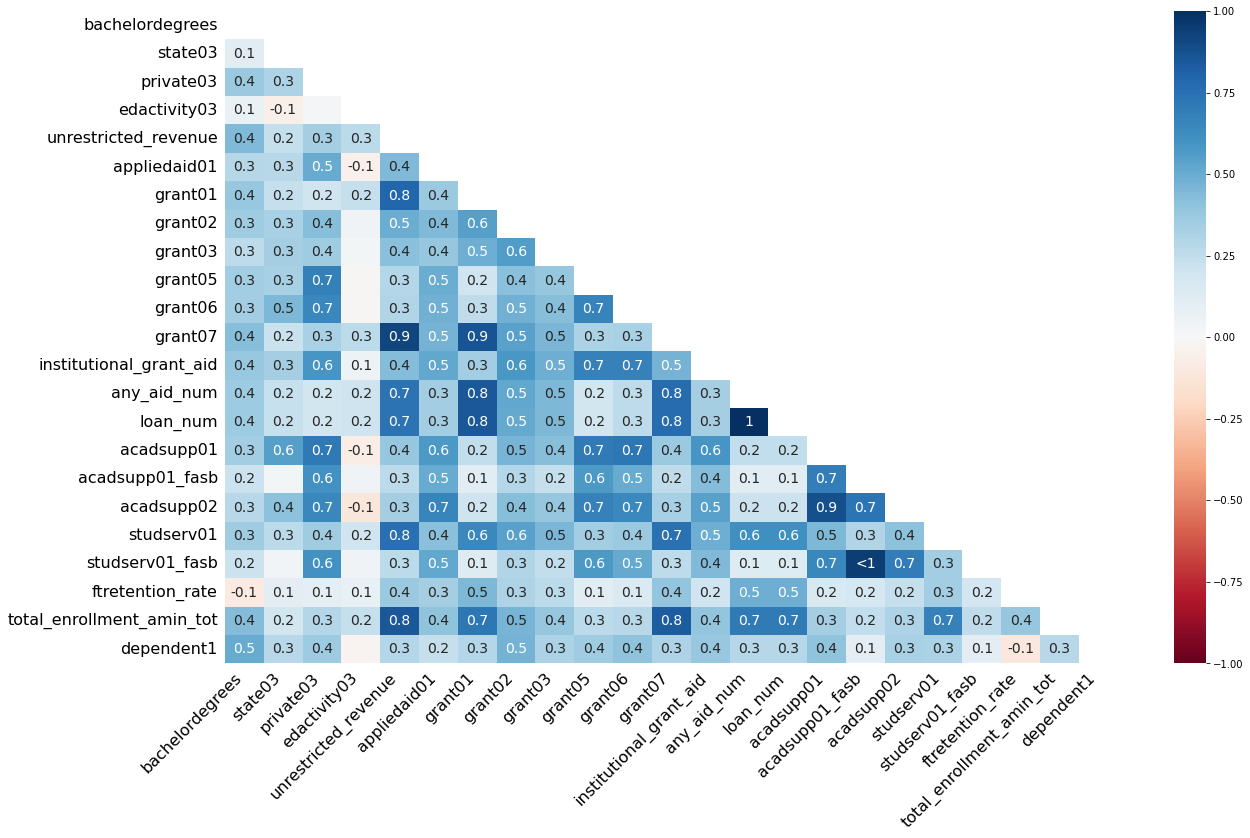

In [7]:
msno.heatmap(df_subset)

##### Understainding the dendrogram
If a number of columns are grouped together at level zero, then the presence of nulls in one of those columns is directly related to the presence or absence of nulls in the others columns. The more separated the columns in the tree, the less likely the null values can be correlated between the columns.

<AxesSubplot:>

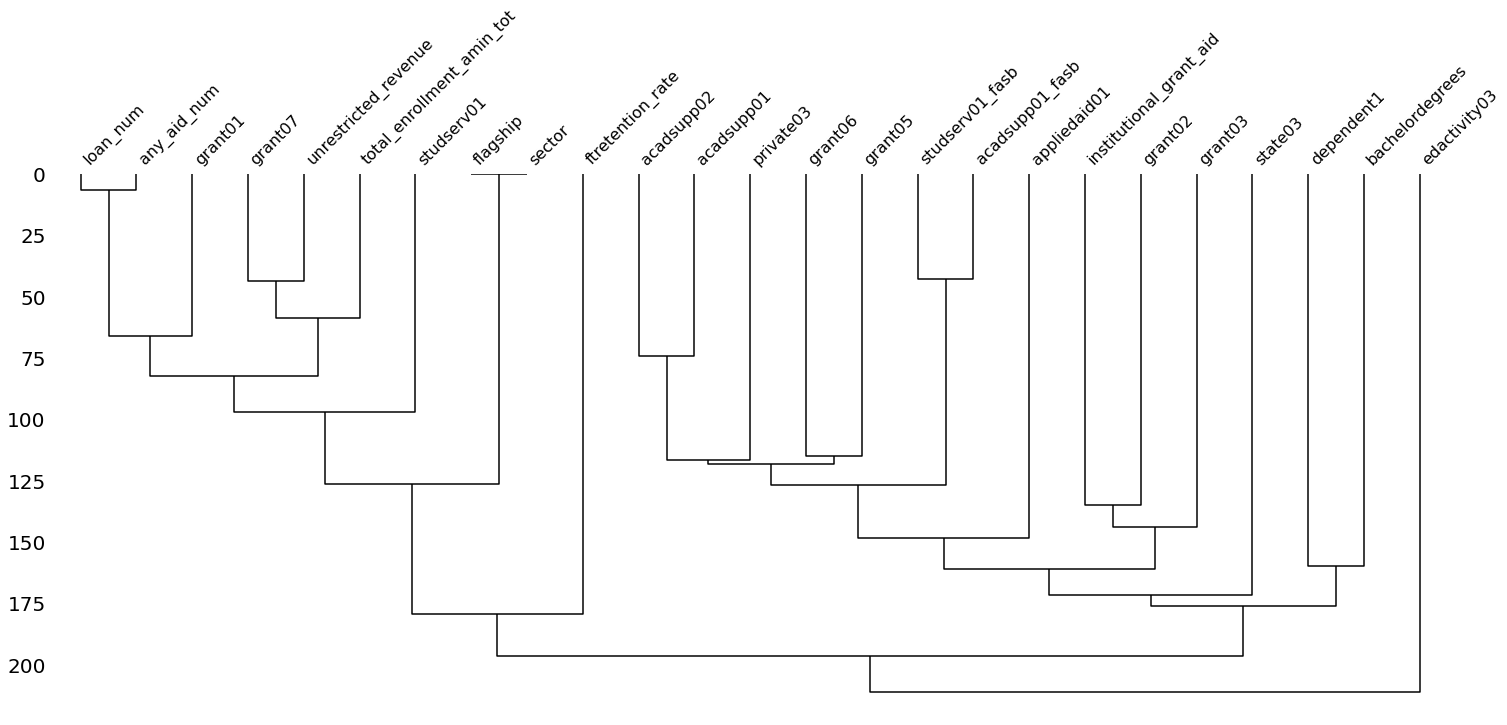

In [8]:
msno.dendrogram(df_subset)

#### Missing values are missing not at random (MNAR)
Fromt our exploration we can conclude that the missing data depends equally on the missing and observed values. In this method, handling the missing values is usually impossible, as it depends on the unseen data<a href ="https://link.springer.com/chapter/10.1007/978-1-4614-4018-5_2"> [5] </a>. Therefore dropping missing values would not be a great method in handling them as that is usually done for data missing at random or completely at random. "Many researchers, however, report that the easiest way is to complete all the missing data as MAR to some degree because MAR resides in the middle of this continuum <a href="https://www.annualreviews.org/doi/10.1146/annurev.psych.58.110405.085530"> [6] </a>."
In my case if a column contains a lot of missing values, say more than 75% and the feature is not significant, I will delete that feature. However, this is not a preferable methodology. Here specifically I am adding bias.

<AxesSubplot:>

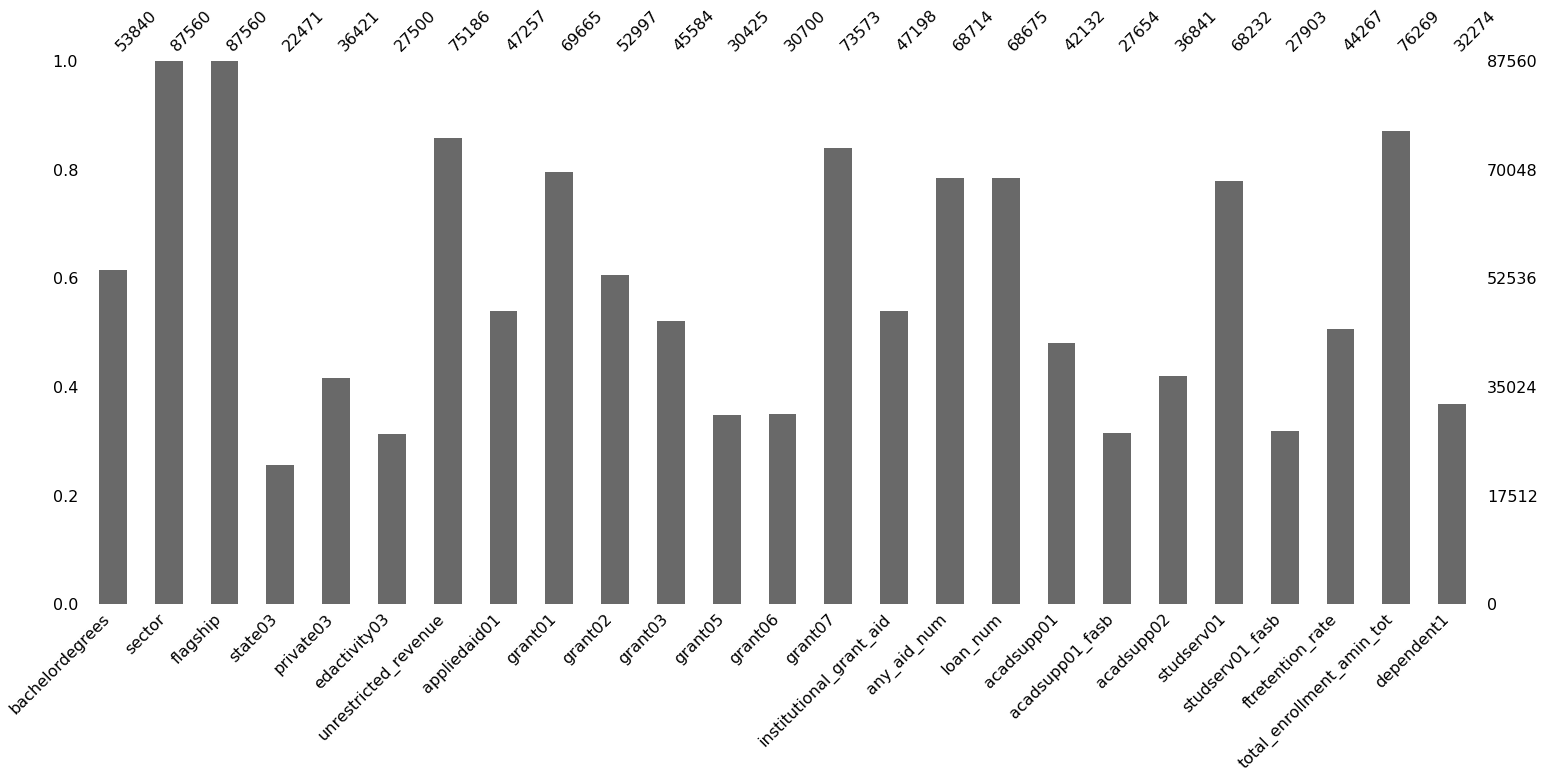

In [4]:
# Missing values as a percentage
# Lower bar means more missing 
msno.bar(df_subset)

<AxesSubplot:>

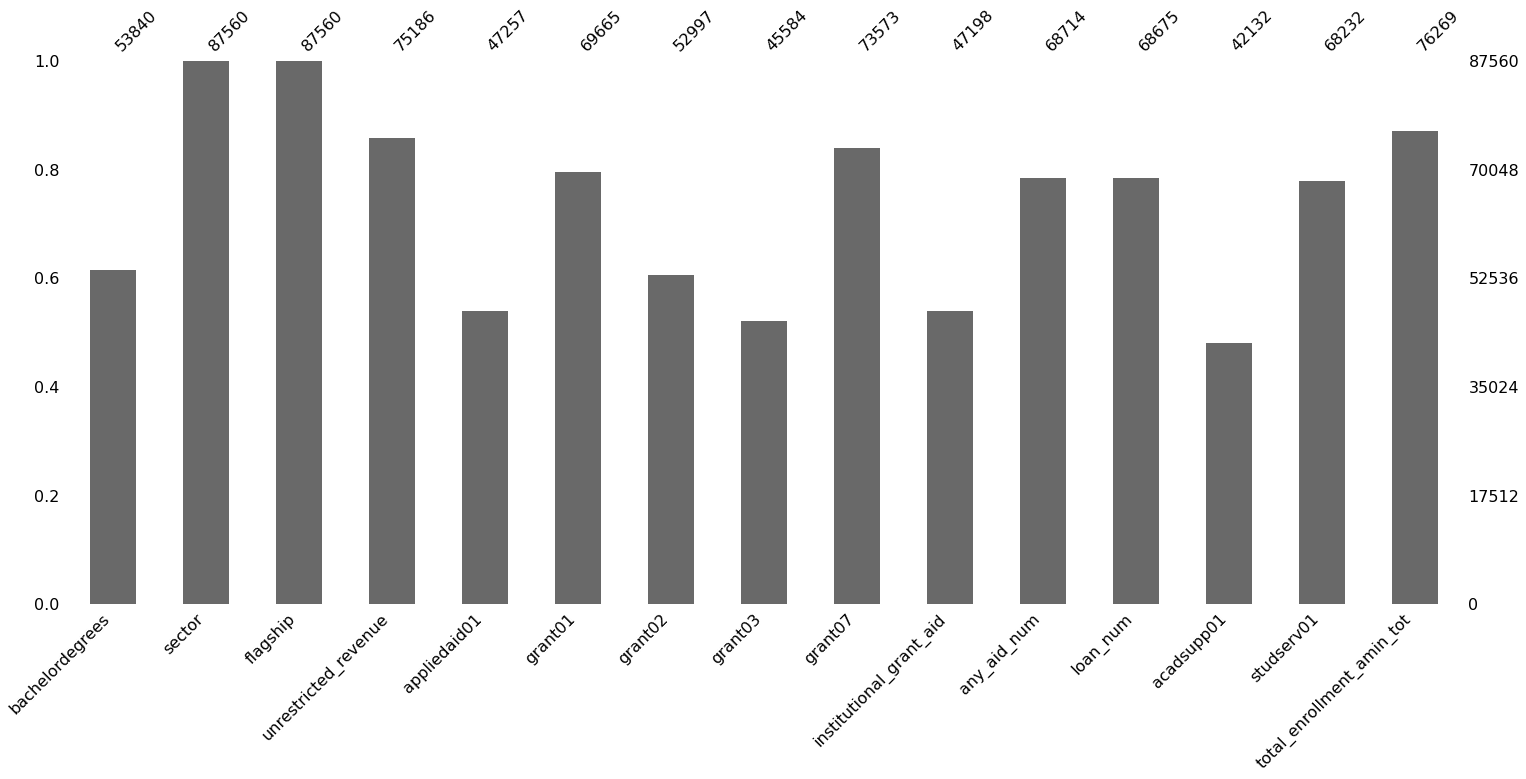

In [5]:
# Filtering out columns
df_subset = df[['bachelordegrees','sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot'
               ]]
msno.bar(df_subset)

#### Imputation Techniques
The process of imputation involves replacing missing values by some predicted values. Iterative imputation refers to a process where each feature is modeled as a function of the other features. Let us use regression as an exmaple. Each feature is imputed sequentially allowing prior imputed values to be used as part of a model in predicting subsequent features. This process is repeated many times, allowing us to adjust values of the missing values from before as we predict new ones. I used a Bayesian ridge regression because it assumes that the target variable is assumed to drawn from a probability distribution rather than estimated as a single value. The target is also assumed to be Gaussian distributed around X. Therefore to extract the maximum out of this method I employed the standard scaler. The standard scaler (z = (x - u) / s) standardizes features by removing the mean and scaling to unit variance. This way the data would be close Gaussian with mean 0 and variance 1. Finally I used the initial strategy median due to the fact that the dataset is skewed right. This means that the iterative imputer will initially impute the missing values with the median as it is a better measure of the central tendency of data. 

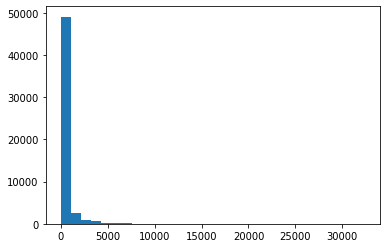

,bachelordegrees,sector,flagship,unrestricted_revenue,appliedaid01,grant01,grant02,grant03,grant07,institutional_grant_aid,any_aid_num,loan_num,acadsupp01,studserv01,total_enrollment_amin_tot
0,-0.321894,-0.348016,-0.083828,-0.232016,-0.380222,-0.188638,-0.162786,-0.217300,-0.268594,-0.286843,-0.394720,-0.305537,-0.276355,-0.311446,-0.199846
1,-0.482659,0.593571,-0.083828,-0.243201,-0.371982,-0.266650,-0.204360,-0.253865,-0.312701,-0.287998,-0.387613,-0.301516,-0.263206,-0.385223,-0.222839
2,0.143741,-0.504947,-0.083828,-0.127585,-0.284485,0.118888,-0.177428,-0.261232,-0.091767,-0.203535,0.103902,0.160137,-0.195098,-0.008664,-0.107873
3,-0.493708,0.593571,-0.083828,-0.244622,-0.366990,-0.248680,-0.233750,-0.293677,-0.306113,-0.272853,-0.393705,-0.304197,-0.269152,-0.404135,-0.222839
4,-0.348030,0.122778,-0.083828,-0.242150,-0.380303,-0.251609,-0.228889,-0.228710,-0.302735,-0.288347,-0.304354,-0.192925,-0.279875,-0.312862,-0.207511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87555,-0.319078,-0.348016,-0.083828,-0.219735,-0.377695,-0.164740,-0.218551,-0.244714,-0.266586,-0.281735,-0.373398,-0.284087,-0.287756,-0.319660,-0.215175
87556,-0.313445,-0.348016,-0.083828,-0.197734,-0.368948,-0.186408,-0.221655,-0.244686,-0.264063,-0.268760,-0.385582,-0.298834,-0.280425,-0.352288,-0.215175
87557,-0.337853,-0.348016,-0.083828,-0.239294,-0.378355,-0.249708,-0.226528,-0.239553,-0.303056,-0.285109,-0.396751,-0.308219,-0.301620,-0.380290,-0.215175
87558,-0.333159,-0.348016,-0.083828,-0.236203,-0.377784,-0.237592,-0.227282,-0.244801,-0.295395,-0.281564,-0.395736,-0.308219,-0.293329,-0.343114,-0.222839


In [8]:
plt.hist(df_subset.bachelordegrees, bins = 30)
plt.show()

# Scaling
scaler = StandardScaler()
df_mice = scaler.fit_transform(df_subset)
# Implementing Iterative Imputer
imp = IterativeImputer(max_iter = 100, initial_strategy='median',
                      imputation_order = 'roman',sample_posterior=False)
df_mice = imp.fit_transform(df_mice)
# Convert to dataframe
df_mice = pd.DataFrame(df_mice, columns = ['bachelordegrees','sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot'])
df_mice

#### Recursive Feature Elimination
RFE works by searching for a subset of features, starting with all features in the training dataset and removing features it deems unimportant. This is achieved by fitting a machine learning algorithm (in this case random forest), ranking features by importance (using cross validation score), discarding the least important features, and refitting the model<a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">[7] </a>. 
The goal of this step is removing any unecessary noise. From the results below we got an index containing all the variables which means all of them are important which is great to see.

In [12]:
y = df_mice[['bachelordegrees']]
X = df_mice[['sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)
rfecv = RFECV(estimator=RandomForestRegressor(),min_features_to_select=5,step=5, n_jobs=-1, 
              scoring='neg_mean_squared_error', cv=5,)
_ = rfecv.fit(X_train, y_train.values.ravel())
X_train.columns[rfecv.support_]

Index(['sector', 'flagship', 'unrestricted_revenue', 'appliedaid01', 'grant01',
       'grant02', 'grant03', 'grant07', 'institutional_grant_aid',
       'any_aid_num', 'loan_num', 'acadsupp01', 'studserv01',
       'total_enrollment_amin_tot'],
      dtype='object')

#### GridSearchCV // Hyperparameter Tuning
GridSearch helps to loop through predefined hyperparameters and fit the model on the training set so in the end, we can get the best parameters. The reason I did not fully commit to using the output estimator is because random forests tend to overfit (personal experience).

In [13]:
estimator = RandomForestRegressor()
para_grids = {
            "n_estimators" : [100,150,200,250],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }
grid = GridSearchCV(estimator, para_grids, scoring = 'neg_mean_squared_error',n_jobs=-1)
grid.fit(X_train, y_train.values.ravel())
grid.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='sqrt', n_estimators=150)

#### Understanding the Learning Curve
Learning curve determines cross-validated training and test scores for different training set sizes. A cross-validation generator splits the whole dataset 10 times in training and test data. Using learning curve we can better evaluate the model's performance. 

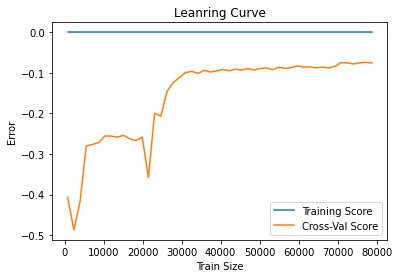

In [14]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=150),
    X,y.values.ravel(), cv =10,scoring='neg_mean_squared_error',n_jobs = -1,
    train_sizes=np.linspace(0.01,1,50))

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean, label = 'Training Score')
plt.plot(train_sizes,test_mean,label = 'Cross-Val Score')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')

plt.title('Leanring Curve')
plt.xlabel('Train Size')
plt.ylabel('Error')
plt.legend(loc='best')

#### Results
From the graph above we can see that the model is definitely overfitting. This is because the the model peroforms well on the training data, but when it is introduced to new data it tends to underperform. Ideally the blue and orange line should overlap or be extremly close. Additionally, our r-squared is 0.97 which means that the 97% of the variation in bachelordegrees is explained by our variables. Also our mean squared error which is the avergae of all squared differences between actual value and predicted value is low.<br>
<br>
Lastly the top 3 most important features/variables model says helped the most to predict bachelorsdegrees are unrestricted_revenue, acadsupport01, any_aid_num. This is by no means a groundbreaking finding, but could still be useful.<br>
<br>
Description of the 3 variables:

- unrestricted_revenue: All funds received for which no stipulation was made by the donor or other external agency as to the purpose for which the funds should be expende (includes tuition, state and local appropriations, and private gifts, investment returns, and endowment income).<br>
<br>
- acadsupport01: A functional expense category that includes expenses of activities and services that support the institution's primary missions of instruction, research, and public service. It includes the retention, preservation, and display of educational materials (for example, libraries, museums, and galleries); organized activities that provide support services to the academic functions of the institution (such as a demonstration school associated with a college of education or veterinary and dental clinics if their primary purpose is to support the instructional program); media such as audiovisual services; academic administration (including academic deans but not department chairpersons); and formally organized and separately budgeted academic personnel development and course and curriculum development expenses. Also included are information technology expenses related to academic support activities; if an institution does not separately budget and expense information technology resources, the costs associated with the three primary programs will be applied to this function and the remainder to institutional support.  Operations and maintenance and interest amounts attributed to the academic support function have been subtracted from the total academic support expenditure amount at FASB reporting institutions. Operations and maintenance amounts (and interest in the 2009 aligned form) attributed to the academic support function have been subtracted from the total academic support expenditure amount at public Aligned Form reporting institutions.<br>
<br>
- any_aid_num: Number of full-time, first-time degree/certificate-seeking undergraduate students who received any financial aid including grants, loans, assistantships, scholarships, fellowships, tuition waivers, tuition discounts, veteran's benefits, employer aid (tuition reimbursement) and other monies (other than from relatives/friends) provided to students to meet expenses. This includes Title IV subsidized and unsubsidized loans made directly to students.

Mean Squared Error: 0.027428812245839873
R^2: 0.9651947534023932


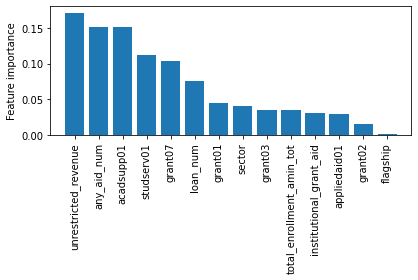

In [15]:
rf_final = RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=150)
rf_final.fit(X_train, y_train.values.ravel())


y_pred = rf_final.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

importances = rf_final.feature_importances_

indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = df_mice.columns[1:]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

#### KNN Imputation With the Same Approach

I used the knn imputer as a as a seperate dataset just to see the difference. The idea in kNN methods is to identify 'k' samples in the dataset that are similar or close in the space. Then we use these 'k' samples to estimate the value of the missing data points. Each sample's missing values are imputed using the mean value of the 'k'-neighbors found in the dataset. kNN might be a good way to impute the data as it depends on the variables around it and since we concluded that some of the data is missing because of others, it might give us better results.

In [6]:
scaler = StandardScaler()
knn=KNNImputer()
df_knn =  scaler.fit_transform(df_subset)
df_knn = knn.fit_transform(df_knn)
df_knn = pd.DataFrame(df_knn, columns = ['bachelordegrees','sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot'])
df_knn

,bachelordegrees,sector,flagship,unrestricted_revenue,appliedaid01,grant01,grant02,grant03,grant07,institutional_grant_aid,any_aid_num,loan_num,acadsupp01,studserv01,total_enrollment_amin_tot
0,-0.321894,-0.348016,-0.083828,-0.232016,-0.380222,-0.188638,-0.162786,-0.217300,-0.268594,-0.285878,-0.394720,-0.305537,-0.274646,-0.311446,-0.199846
1,-0.340670,0.593571,-0.083828,-0.243201,-0.371982,-0.266650,-0.228244,-0.243674,-0.312701,-0.287998,-0.387613,-0.301516,-0.295485,-0.385223,-0.222839
2,0.143741,-0.504947,-0.083828,-0.127585,-0.284485,0.118888,-0.096703,-0.091407,-0.091767,-0.203535,-0.298059,-0.211157,-0.236786,-0.156400,-0.107873
3,-0.340670,0.593571,-0.083828,-0.244622,-0.367936,-0.248680,-0.227569,-0.241470,-0.306113,-0.288004,-0.393705,-0.304197,-0.294080,-0.382469,-0.222839
4,-0.340670,0.122778,-0.083828,-0.242150,-0.380303,-0.251609,-0.228889,-0.228710,-0.302735,-0.288347,-0.304354,-0.192925,-0.288297,-0.312862,-0.207511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87555,-0.319078,-0.348016,-0.083828,-0.219735,-0.377695,-0.164740,-0.218551,-0.244714,-0.266586,-0.281735,-0.373398,-0.284087,-0.277107,-0.319660,-0.215175
87556,-0.313445,-0.348016,-0.083828,-0.197734,-0.368948,-0.186408,-0.221655,-0.244686,-0.264063,-0.268760,-0.385582,-0.298834,-0.266799,-0.352288,-0.215175
87557,-0.337853,-0.348016,-0.083828,-0.239294,-0.378355,-0.249708,-0.226528,-0.242485,-0.303056,-0.285109,-0.396751,-0.308219,-0.282326,-0.380290,-0.215175
87558,-0.333159,-0.348016,-0.083828,-0.236203,-0.377784,-0.237592,-0.227282,-0.244801,-0.295395,-0.281564,-0.395736,-0.308219,-0.286494,-0.343114,-0.222839


In [17]:
y = df_knn[['bachelordegrees']]
X = df_knn[['sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)
rfecv = RFECV(estimator=RandomForestRegressor(),min_features_to_select=5,step=5, n_jobs=-1, 
              scoring='neg_mean_squared_error',cv=5,)
_ = rfecv.fit(X_train, y_train.values.ravel())
X_train.columns[rfecv.support_]

Index(['sector', 'flagship', 'unrestricted_revenue', 'appliedaid01', 'grant01',
       'grant02', 'grant03', 'grant07', 'institutional_grant_aid',
       'any_aid_num', 'loan_num', 'acadsupp01', 'studserv01',
       'total_enrollment_amin_tot'],
      dtype='object')

In [18]:
estimator = RandomForestRegressor()
para_grids = {
            "n_estimators" : [100,150,200,250],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }
grid = GridSearchCV(estimator, para_grids, scoring = 'neg_mean_squared_error',n_jobs=-1)
grid.fit(X_train, y_train.values.ravel())
grid.best_estimator_

RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=150)

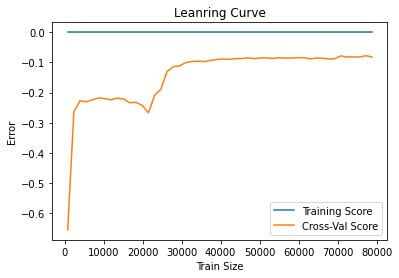

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=150),
    X,y.values.ravel(), cv =10,scoring='neg_mean_squared_error',n_jobs = -1,
    train_sizes=np.linspace(0.01,1,50))

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean, label = 'Training Score')
plt.plot(train_sizes,test_mean,label = 'Cross-Val Score')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')

plt.title('Leanring Curve')
plt.xlabel('Train Size')
plt.ylabel('Error')
plt.legend(loc='best')

Mean Squared Error: 0.018420406638650685
R^2: 0.9705129602101442


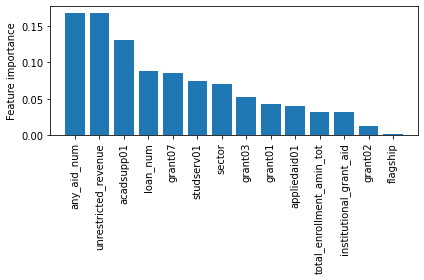

In [20]:
rf_final = RandomForestRegressor(bootstrap=False, max_features='log2', n_estimators=200)
rf_final.fit(X_train, y_train.values.ravel())

y_pred = rf_final.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1]

plt.ylabel('Feature importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')

feat_labels = df_mice.columns[1:]
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)

plt.xlim([-1, X_train.shape[1]])

plt.tight_layout()
plt.show()

#### Regularization
Now that we have some sort of baseline, we need to further tweak the model. The literature simply made their models without sharing their code and made no mention of regularization. They simply threw more models at the problem. In this section I will use the baseline and manually tweak the model to not overfit.<br>
<br>
To regularize a random forest these are the priciples I followed:
- n_estimators: The more trees, the less likely the algorithm is to overfit.
- max_features: Try reducing this number. 
- max_depth: This parameter will reduce the complexity of the learned models, lowering over fitting risk.
- min_samples_leaf: Try setting these values greater than one.

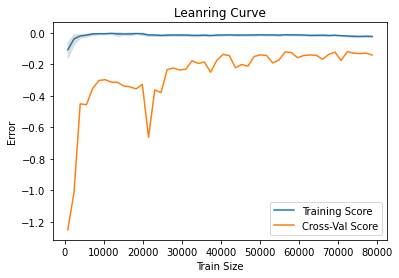

In [21]:
y = df_knn[['bachelordegrees']]
X = df_knn[['sector','flagship',
                'unrestricted_revenue','appliedaid01',
                'grant01','grant02','grant03','grant07',
                'institutional_grant_aid',
               'any_aid_num','loan_num','acadsupp01','studserv01'
               ,'total_enrollment_amin_tot']]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(bootstrap=True, max_features=2, n_estimators=2,max_depth=50,min_samples_leaf=2),
    X,y.values.ravel(), cv =10,scoring='neg_mean_squared_error',n_jobs = -1,
    train_sizes=np.linspace(0.01,1,50))

train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(train_sizes,train_mean, label = 'Training Score')
plt.plot(train_sizes,test_mean,label = 'Cross-Val Score')

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color = '#DDDDDD')

plt.title('Leanring Curve')
plt.xlabel('Train Size')
plt.ylabel('Error')
plt.legend(loc='best')

In [7]:
# Further testing the top 3 variables

y = df_knn[['bachelordegrees']]
X = df_knn[['unrestricted_revenue', 'any_aid_num','acadsupp01']]
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)

rf_final = RandomForestRegressor(bootstrap=True, max_features=2, n_estimators=2,max_depth=50,min_samples_leaf=2,n_jobs=-1)
rf_final.fit(X_train, y_train.values.ravel())

y_pred = rf_final.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 0.11071981603243936
R^2: 0.8488442119002098


In [9]:
y = df_knn[['bachelordegrees']]
X = df_knn[['unrestricted_revenue', 'any_aid_num','acadsupp01']]

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size= 0.2)

rf_final = RandomForestRegressor(bootstrap=True, max_features=2, n_estimators=2,max_depth=50,min_samples_leaf=2,n_jobs=-1)
rf_final.fit(X_train, y_train.values.ravel())

y_pred = rf_final.predict(X_test)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('R^2:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 0.11039255087066084
R^2: 0.8430942228403735


### Limitations // Further Work 
This work has several limitations. First limitation is the dataset itself. There is a vast number of missing values for every variable. In addition to that, there is also a ton of bias as I used Pearson correlation to filter out the variables and hand picked the ones with the lowest amount of missing values. It is also important to conisder the fact that multiple imputation could also increase correlation between these variables, which is the reason for overfitting. Overfitting is not good thing as the model is not good at making general solutions, only specific results which could mean our tatget variable may vary greatly depending on the input values. In other words, changing one value could make an obscure prediction, completely different than before.<br>
<br>
For further research my suggestion is sticking with tree methods by using a simpler version of the random forest, decistion trees. Decision trees tend to perform worse than random forest which could be a good way to mitigate overfitting. In case that the decision tree is performing poorly (weak learner), using AdaBoost or Gradient Boosting would be a great way to bring it up to speed. Other possibility is simply using sklearn's model_selection feature to select a the best model using cross validation score. 

### Conclusion
Overall the model identified funding and academic support as most imporant variables. Further testing showed that the 3 variables accounted for 85% of variance in bachelor degrees awarded. Therefore it should be in a higher ed institutions interest to maximize these. If the school already has this data then it can make a fairly future prediction for awards that year. 


### References

[1] Uskov, Vladimir  L, et al. “Machine Learning-Based Predictive Analytics of Student Academic Performance in STEM Education.” IEEE Xplore, 2019, https://ieeexplore.ieee.org/abstract/document/8725237. <br>
[2] Ahadi, Alireza, et al. Exploring Machine Learning Methods to ... - Opus at UTS: Home. https://opus.lib.uts.edu.au/bitstream/10453/37496/5/2015_08_ICER_AhadiEtAl_ExploringMachineLearningMethods_AcceptedManuscript.pdf.<br> 
[3] Golino, Hudson  F, et al. “Predicting Academic Achievement of High-School Students Using Machine Learning.” Scirp.org, Scientific Research Publishing, 24 Nov. 2014, https://www.scirp.org/html/9-6901327_51702.htm?pagespeed=noscript.<br>
[4] Emmanuel, Tlamelo, et al. “A Survey on Missing Data in Machine Learning - Journal of Big Data.” SpringerOpen, Springer International Publishing, 27 Oct. 2021, https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00516-9. <br>
[5] Graham, John W. “Analysis of Missing Data.” SpringerLink, Springer New York, 1 Jan. 1970, https://link.springer.com/chapter/10.1007/978-1-4614-4018-5_2. <br>
[6] John W. Graham. “Missing Data Analysis: Making It Work in the Real World.” Annual Reviews, Department of Biobehavioral Health and the Prevention Research Center, 10 Jan. 2008, https://www.annualreviews.org/doi/10.1146/annurev.psych.58.110405.085530. <br>
[7] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html